**TODO**:
* compute Granger Causality Index, Direct Transfer Function, Partial Directed Coherence
* **Problem:** All metrics depend on MAR coeff in frequency domain. How does one compute them?
* 

https://en.wikipedia.org/wiki/Brain_connectivity_estimators

# 1. Coherence

For a random time-signal $x(t)$ defined on $t \in [0, T]$ it's Truncated Fourier transform is defined as

$$x(\omega) = \mathcal{F}\{x(t)\} = \frac{1}{T} \int_{0}^T x(t) e^{-i\omega t} dt$$

It's power spectral density (PSD) is defined as

$$S_{xx}(\omega) = \lim_{T \rightarrow \infty}E \bigl[ |x(\omega)|^2 \bigr]$$

The PSD $S_{xx}$ quantifies the amount of power stored in a given frequency $\omega$. Given another time-signal $y(t)$ a cross-spectral density (CSD) can be defined as

$$S_{xy}(\omega) = \lim_{T \rightarrow \infty}E \bigl[ \langle x(\omega)| y(\omega) \rangle \bigr]$$

The CSD $S_{xy}$ quantifies how much of the power stored in $x$ and $y$ at that frequency is phase-aligned. Namely, if both signals are in-phase, they are fully aligned, whereas if they are shifted by 90 degrees wrt each other, they are orthogonal and CSD is zero.

Coherence is interested only in estimating the phase angle, invariant of the actual power contained in the signals.

$$
C_{xy}(\omega)
= |\cos(\theta)|
= \frac{|\vec{x} \cdot \vec{y}|}{|x||y|}
= \frac{|S_{xy}(\omega)|^2}{S_{xx}(\omega) S_{yy}(\omega)}
$$

According to the Wiener-Khinchin theorem, the PSD can be rewritten as fourier transform of autocorrelation

$$S_{xx}(\omega) = \mathcal{F}\{ R_{xx}(\tau) \}$$

By the same principles, the CSD is related to cross-correlation

$$S_{xy}(\omega) = \mathcal{F}\{ R_{xy}(\tau) \}$$

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from mesostat.utils.signals import approx_decay_conv

from scipy.signal import periodogram, correlate, csd, coherence
from scipy.fftpack import fft

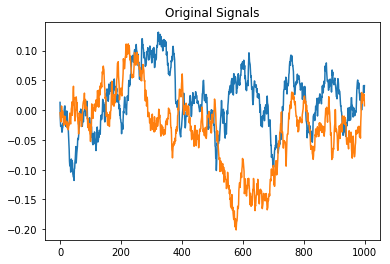

In [39]:
# Generate some non-trivial signals
dt = 1
tau = 100
nStep = 1000

x = np.random.normal(0,1,nStep)
y = np.random.normal(0,1,nStep)

x = approx_decay_conv(x, tau, dt)
y = approx_decay_conv(y, tau, dt)

plt.figure()
plt.plot(x)
plt.plot(y)
plt.title('Original Signals')
plt.show()

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


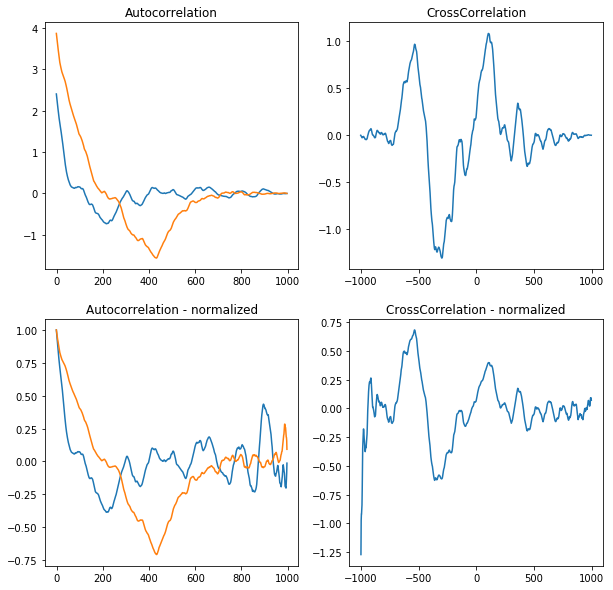

In [43]:
def crosscorr(x, y, pearson=False):
    assert len(x) == len(y), "currently only defined for equal length signals"
    
    xCent = x - np.mean(x)
    yCent = y - np.mean(y)
    
    n = len(x)
    t = np.arange(2*n - 1) - n - 1
    ac = np.correlate(xCent, yCent, mode="full")
    if not pearson:
        return t, ac
    else:
        stdX = np.std(x)
        stdY = np.std(y)
        idxs = n - np.abs(np.arange(2*n - 1) - n - 1)
        return t, ac / stdX / stdY / idxs
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

t, acX = crosscorr(x, x)
t, acY = crosscorr(y, y)
t, ccXY = crosscorr(x, y)

t, acXnorm = crosscorr(x, x, pearson=True)
t, acYnorm = crosscorr(y, y, pearson=True)
t, ccXYnorm = crosscorr(x, y, pearson=True)

ax[0, 0].plot(t[nStep-1:], acX[nStep-1:])
ax[0, 0].plot(t[nStep-1:], acY[nStep-1:])
ax[0, 0].set_title("Autocorrelation")

ax[1, 0].plot(t[nStep-1:], acXnorm[nStep-1:])
ax[1, 0].plot(t[nStep-1:], acYnorm[nStep-1:])
ax[1, 0].set_title("Autocorrelation - normalized")

ax[0, 1].plot(t, ccXY)
ax[0, 1].set_title("CrossCorrelation")

ax[1, 1].plot(t, ccXYnorm)
ax[1, 1].set_title("CrossCorrelation - normalized")

plt.show()

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


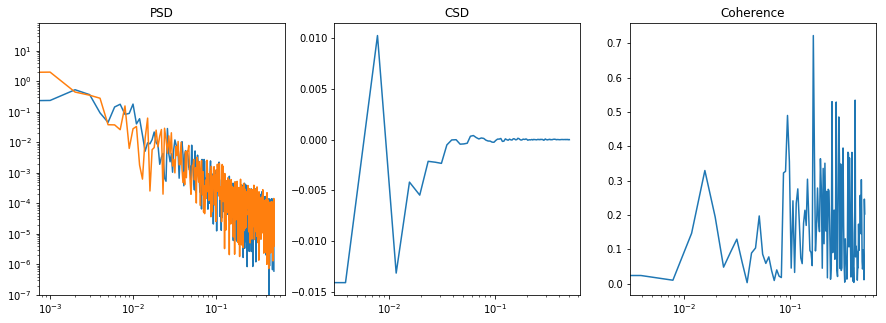

In [44]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

freqX, psdX = periodogram(x, fs = 1/dt)
freqY, psdY = periodogram(y, fs = 1/dt)

ax[0].loglog(freqX, psdX)
ax[0].loglog(freqY, psdY)
ax[0].set_title('PSD')
ax[0].set_ylim([1.0E-7, None])

freqXY, csdXY = csd(x, y, fs = 1/dt)
ax[1].semilogx(freqXY, csdXY)
ax[1].set_title('CSD')

freqXY, cohXY = coherence(x, y, fs = 1/dt)
ax[2].semilogx(freqXY, cohXY)
ax[2].set_title('Coherence')

plt.show()